# <u>Intro to Neural Networks 2</u>
## Gradient Descent, Backpropogation of Errors, and Combinitorial Explosions
<img src="https://blog.paperspace.com/content/images/2018/05/challenges-1.png" alt="title" title="titl"/>
<img src="https://cdn-images-1.medium.com/max/1000/1*lIthvknHt9Tok5aIj4e__g.png" alt="abstraction" title="abstraction"/>


___
<p style="page-break-after:always;"></p>

# 1. The Limitations of The Perceptron
<img src="https://www.lucidarme.me/wp-content/uploads/2017/12/perceptron-2.png" alt="perc" title="percs"/>

___

<p style="page-break-after:always;"></p>

## The Perceptron (Revisited)
___


The Artificial Neuron, or Perceptron is not a new invention. The Perceptron has existed since 1957, but until recent years it was all but forgotten.

The first Perceptron was invented in 1957 at the Cornell Aeronautical Laboratory by Frank Rosenblatt, heavily funded by the US Navy.

The Perceptron was intended to be a standalone machine, not a program. It's first implementation was in software for the IBM 704. Soon custom hardware was developed for it, and it was named the "Mark 1 Perceptron".

It was designed for image recognition and used 400 photocells. Weights were encoded in potentiometers, not software. Weight updates during learning were performed by electric motors.


<img src="https://upload.wikimedia.org/wikipedia/en/thumb/5/52/Mark_I_perceptron.jpeg/220px-Mark_I_perceptron.jpeg" alt="perc1" title="perc1"/>

> Mark I Perceptron machine, the first implementation of the perceptron algorithm. It was connected to a camera with 20×20 cadmium sulfide photocells to make a 400-pixel image. The main visible feature is a patch panel that set different combinations of input features. To the right, arrays of potentiometers that implemented the adaptive weights.
___

**At first, the peceptron seemed promising. The Navy believed the perceptron could become a computer concious of its own existence, until in 1969 a famous book titled *Perceptrons* by Marvin Minsky and Seymour Papert showed that it was impossible for the perceptron to learn the XOR function. It is often believed (incorrectly that they also conjectured that a similar result would hold for a multi-layer perceptron network. However, this is not true. Nevertheless, The young Artificial Intelligence community quickly became skeptical. The often miscited Minsky/Papert text caused a significant decline in further research and support.**




___



<p style="page-break-after:always;"></p>


## The XOR Function (Exclusive OR)


The XOR, or “exclusive or”, problem was a classic problem in neural network research. It is the problem of using a neural network to predict the outputs of XOR logic gates given two binary inputs. An XOR function should return a true value if the two inputs are not equal and a false value if they are equal. All possible inputs and predicted outputs are shown in figure 1.

<img src="https://www.dyclassroom.com/image/topic/logic-gate/xor-xnor/xor-table.png" alt="XOR" title="XOR" height="200" width="300"/>

**A single Neuron cannot be used to handle the XOR function, because its outputs are not linearly seperable - in 2 dimensional space, a single line cannot be drawn to represent a proper decision boundary.**
___
>*The figure below shows that both the **AND** and **OR** functions are linearly seperable*

<img src="https://i.imgur.com/ZUgEwLw.jpg" alt="andor" title="andor"/>
<p style="page-break-before:always;"></p>

### However, solving the XOR function with a single neuron is impossible
<img src="https://cdn-images-1.medium.com/max/800/1*wEomny4n9fzKL7X9TABWjw.png" alt="XOR" title="XOR"/>


### Correct classification of XOR requires atleast two decision boundaries - but contrary to the doubts decades earlier, a Neural Network can learn the concept of XOR.
<img src="https://i.imgur.com/hc1PTO8.jpg" alt="XOR" title="XOR"/>
<p style="page-break-after:always;"></p>

# 2. Connecting the Dots
___

<img src="http://aa.ssdi.di.fct.unl.pt/Lectures/lec/images08/L08-xorplot-2.png" alt="bounds" title="bound" height="300" width="400"/>


<img src="https://i.imgur.com/Z7X1LtI.jpg" alt="hyperplane" title="hyperplane"/>
<p style="page-break-after:always;"></p>



## Computational Limits
An obvious solution to the aforementioned problem was to stack multiple perceptrons together. Although, there was a problem with that. When Rosenblatt introduced the perceptron, he also introduced the perceptron learning rule (the algorithm used to calculate the correct weights for a perceptron automatically). The rule wasn't designed for use with multiple perceptrons, and as such it didn't scale well on multi-layered networks of perceptrons, thus making the training process of these machines exponentially more complex.

<img src="https://www.wikitechy.com/technology/wp-content/uploads/2017/05/A-Time-Complexity.png" alt="complexity" title="complexity"/>


**It is possible to model the XOR function if perceptrons are arranged in sequence, but if the output of the network is determined by a relationship of neurons, error must be calculated in terms of that relationship of neurons. Multilayer Neural Networks were thought to be impractical because attempts to train them resulted in combinitorial explosions. A widely accepted solution to this problem was not found until *Learning representations by back-propogating errors* was published in 1986.**
<p style="page-break-before:always;"></p>

______



# 3. Solving XOR
____

In [4]:
import numpy as np
np.random.seed(42)

<img src="http://hyperphysics.phy-astr.gsu.edu/hbase/Electronic/ietron/xor.gif" alt="xor2" title="xor2"/>

### Defining XOR

In [98]:
                   #A|B
inputs = np.array([[0,0],
                   [0,1],
                   [1,0],
                   [1,1]])

                  #Out
outputs= np.array([0,1,1,0])

X = inputs
y = outputs

<p style="page-break-before:always;"></p>


______
<p style="page-break-before:always;"></p>

<p style="page-break-before:always;"></p>



<p style="page-break-before:always;"></p>


### Creating a network structure

In [127]:
class Neural_Network(object):
    def __init__(self):
    
    #Define Network Structure
    
        self.inputLayerSize = 2
        self.outputLayerSize = 1
        self.hiddenLayerSize = 3
        
    #Define Weights (Parameters)
        
        #Assigning a random weight to each input
        self.W1 = np.random.randn(self.inputLayerSize, self.hiddenLayerSize)
        
        #Assigning a random weight to the output of each neuron in the hidden layer
        self.W2 = np.random.randn(self.hiddenLayerSize, self.outputLayerSize)
    
    #Propagate inputs through the network
    
    def forward(self, X):
        
        #The set of values of the hidden layer, determined by the dot product of inputs and their weights 
        self.z2 = np.dot(X, self.W1)
        #The output of the hidden layer after the activation function has been applied
        self.a2 = self.sigmoid(self.z2)
        #Values entering the output layer, determined by the dot product of the hidden layer's activations and their weights
        self.z3 = np.dot(self.a2, self.W2)
        #The ouput of the network, applying the activation function on the output layer
        yHat = self.sigmoid(self.z3)
        return yHat

    #Apply sigmoid activation function to scalar, vector, or matrix

    def sigmoid(self, z):
        return 1/(1+np.exp(-z))
        

In [94]:
NN = Neural_Network()

<p style="page-break-before:always;"></p>

<p style="page-break-before:always;"></p>

<p style="page-break-before:always;"></p>


<p style="page-break-before:always;"></p>

### Introducing XOR to the network

In [95]:
yHat = NN.forward(X)

In [96]:
yHat

array([[0.5389532 ],
       [0.56661758],
       [0.4884118 ],
       [0.51250773]])

In [97]:
y

array([[0.],
       [1.],
       [1.],
       [0.]])

### The network fails to solve XOR (A learning algorithm has not yet been defined)

| Output | Actual |
|----|----|
| 0.71  | 1 |
| 0.80  | 1  |
| 0.73  | 1  |
| 0.80  | 0  |

## Training the Network
___

In order for the model to learn, we need to quantify exactly how wrong its outputs are.

A cost function is needed to interpret the network's errors.

Cost must be calculated from the set of inputs, and the set of their weights. The inputs cannot be changed, so only the weights can be changed to reduce cost.

**But, can it be proved that there exists a combination of weights that solves XOR?**

**If such a combination even exists, how could it be found?**

___
### Imagine this:

   > This network has 9 weights. Suppose there exists a combination of these 9 weights that correctly solves XOR.                                                                                                                    
   > Testing every possible combination of the weights will eventually yield the correct combination.

<p style="page-break-before:always;"></p>


___

<p style="page-break-before:always;"></p>



<p style="page-break-before:always;"></p>



<p style="page-break-before:always;"></p>



<p style="page-break-before:always;"></p>


<p style="page-break-before:always;"></p>
<p style="page-break-before:always;"></p>
<p style="page-break-before:always;"></p>
<p style="page-break-before:always;"></p>
<p style="page-break-before:always;"></p>


____

<p style="page-break-before:always;"></p>

## The Curse of Dimensionality

___

>Suppose the network only has 1 weight.                                                                                                                                                                                       
>To find the optimal value of this weight, such that error is minimized, one can simply test a massive range of values.

### Testing 1000 Possible Values for a Single Weight:


In [ ]:
import time 

weights_to_try = np.linspace(-10,10,1000)
costs = np.zeros(1000)

start_time = time.clock()

#Trying 1000 different weights in the network
for i in range(1000):
    NN.W1[0,0] = weights_to_try[i]
    yHat = NN.forward(X)
    costs[i] = 0.5*sum((y-yHat)**2)

end_time = time.clock()

In [15]:
time_elapsed = end_time - start_time
time_elapsed

0.025193000000000243

> 1000 Different Weights can be tested in 0.025 seconds!                                                                                                                                                                  
> So, 2 weights should take 0.5 seconds? Right?


<p style="page-break-before:always;"></p>


___

<p style="page-break-before:always;"></p>

### Testing 1000 Possible Values for Two Different Weights

In [ ]:

weights_to_try = np.linspace(-10,10,1000)
costs = np.zeros((1000,1000))

start_time = time.clock()

#Trying 1000 different weights in the network
for i in range(1000):
    for j in range(1000):
        NN.W1[0,0] = weights_to_try[i]
        NN.W1[0,1] = weights_to_try[j]
        yHat = NN.forward(X)
        costs[i] = 0.5*sum((y-yHat)**2)

end_time = time.clock()

In [19]:
time_elapsed = end_time - start_time
time_elapsed

17.723762999999998

>Searching through two weights would only take 17.7 seconds

**But searching for three weights would take approximately *Eleven Hours***

In [20]:
0.025*(1000**(9-1))/(3600*24*365)

792744799594114.8

***And searching all nine weights would take (792744799594114.8)...Years. (Longer than the universe has existed)***

### This is the Combinitorial Explosion, and lack of a solution for this exact problem is why research and funding halted for decades.

## Gradient Descent - Navigating N-Dimensional Space

___



<img src="http://www.its.caltech.edu/~nazizanr/imgs/nonconvex3.jpg" alt="gd" title="gd"/>


___
#### Consider the 3-dimensional graph below in the context of a cost function. Our goal is to move from the mountain in the top right corner (high cost) to the dark blue sea in the bottom left (low cost). The arrows represent the direction of steepest descent (negative gradient) from any given point–the direction that decreases the cost function as quickly as possible

<img src="https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent.png" alt="gd" title="gd"/>

#### Starting at the top of the mountain, we take our first step downhill in the direction specified by the negative gradient. Next we recalculate the negative gradient (passing in the coordinates of our new point) and take another step in the direction it specifies. We continue this process iteratively until we get to the bottom of our graph, or to a point where we can no longer move downhill–a local minimum. 

<img src="https://ml-cheatsheet.readthedocs.io/en/latest/_images/gradient_descent_demystified.png" alt="gd" title="gd"/>

#### The size of these steps is called the learning rate. With a high learning rate we can cover more ground each step, but we risk overshooting the lowest point since the slope of the hill is constantly changing. With a very low learning rate, we can confidently move in the direction of the negative gradient since we are recalculating it so frequently. A low learning rate is more precise, but calculating the gradient is time-consuming, so it will take us a very long time to get to the bottom.


## Calcluating Gradients
___
<img src="https://image.slidesharecdn.com/machinelearning-talk-140315185910-phpapp02/95/utah-code-camp-2014-learning-from-data-by-thomas-holloway-19-638.jpg?cb=1394910152" alt="gd" title="gd"/>

The goal of Gradient Descent is to move in the direction of a local or global minimum in N-dimensional space.                                                                                                              
This can be described as the rate of change of the cost function(J), with respect to weights(W).
This can be achieved by solving for a partial derivative for each weight 

We can derive an expression for $\frac{\partial J}{\partial W}$ that will give us the rate of change of J with respect to W for any value of W. 


> If $\frac{\partial J}{\partial W}$ is positive, the cost function (error) is increasing                                                                                                                                  
If $\frac{\partial J}{\partial W}$ is negative, the cost function (error) is decreasing

**Moving along a bounded gradient like this allows optimal weights to be found, while avoiding the combinitorial explosion.**

<p style="page-break-before:always;"></p>

____
<p style="page-break-before:always;"></p>


<p style="page-break-before:always;"></p>


<p style="page-break-before:always;"></p>



# Solving XOR:


In [57]:
import numpy
import tensorflow as tf
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

In [73]:
def tanh(x):
    return (1.0 - numpy.exp(-2*x))/(1.0 + numpy.exp(-2*x))

def tanh_derivative(x):
    return (1 + tanh(x))*(1 - tanh(x))

def softmax(A):
    e = np.exp(A)
    return  e / e.sum(axis=0).reshape((-1,1))

In [88]:
class NeuralNetwork:
    #########
    # parameters
    # ----------
    # self:      the class object itself
    # net_arch:  consists of a list of integers, indicating
    #            the number of neurons in each layer, i.e. the network architecture
    #########
    def __init__(self, net_arch):
        numpy.random.seed(0)
        
        # Initialized the weights, making sure we also 
        # initialize the weights for the biases that we will add later
        self.activity = tanh
        self.softmax = softmax
        self.activity_derivative = tanh_derivative
        self.layers = len(net_arch)
        self.steps_per_epoch = 1
        self.arch = net_arch
        self.weights = []
        self.multi = False

        # Random initialization with range of weight values (-1,1)
        for layer in range(self.layers - 1):
            w = 2*numpy.random.rand(net_arch[layer] + 1, net_arch[layer+1]) - 1
            self.weights.append(w)
    
    def _forward_prop(self, x):
        y = x

        for i in range(len(self.weights)-1):
            activation = numpy.dot(y[i], self.weights[i])
            activity = self.activity(activation)

            # add the bias for the next layer
            activity = numpy.concatenate((numpy.ones(1), numpy.array(activity)))
            y.append(activity)

        # last layer
        if self.multi == True:
            activation = numpy.dot(y[-1], self.weights[-1])
            activity = self.softmax(activation)
            y.append(activity)
            
        else:
            activation = numpy.dot(y[-1], self.weights[-1])
            activity = self.activity(activation)
            y.append(activity)
        
        return y
    
    def _back_prop(self, y, target, learning_rate):
        error = target - y[-1]
        delta_vec = [error * self.activity_derivative(y[-1])]

        # we need to begin from the back, from the next to last layer
        for i in range(self.layers-2, 0, -1):
            error = delta_vec[-1].dot(self.weights[i][1:].T)
            error = error*self.activity_derivative(y[i][1:])
            delta_vec.append(error)

        # Now we need to set the values from back to front
        delta_vec.reverse()
        
        # Finally, we adjust the weights, using the backpropagation rules
        for i in range(len(self.weights)):
            layer = y[i].reshape(1, self.arch[i]+1)
            delta = delta_vec[i].reshape(1, self.arch[i+1])
            self.weights[i] += learning_rate*layer.T.dot(delta)
    
    #########
    # parameters
    # ----------
    # self:    the class object itself
    # data:    the set of all possible pairs of booleans True or False indicated by the integers 1 or 0
    # labels:  the result of the logical operation 'xor' on each of those input pairs
    #########
    def fit(self, data, labels, learning_rate=0.1, epochs=100, multi = False):
        
        self.multi = multi
        # Add bias units to the input layer - 
        # add a "1" to the input data (the always-on bias neuron)
        ones = numpy.ones((1, data.shape[0]))
        Z = numpy.concatenate((ones.T, data), axis=1)
        
        for k in range(epochs):
            if (k+1) % 75000 == 0:
                print('epochs: {}'.format(k+1))
        
            sample = numpy.random.randint(X.shape[0])

            # We will now go ahead and set up our feed-forward propagation:
            x = [Z[sample]]
            y = self._forward_prop(x)

            # Now we do our back-propagation of the error to adjust the weights:
            target = labels[sample]
            self._back_prop(y, target, learning_rate)
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # x:      single input data
    #########
    def predict_single_data(self, x):
        val = numpy.concatenate((numpy.ones(1).T, numpy.array(x)))
        for i in range(0, len(self.weights)):
            val = self.activity(numpy.dot(val, self.weights[i]))
            val = numpy.concatenate((numpy.ones(1).T, numpy.array(val)))
        return val[1]
    
    #########
    # the predict function is used to check the prediction result of
    # this neural network.
    # 
    # parameters
    # ----------
    # self:   the class object itself
    # X:      the input data array
    #########
    def predict(self, X):
        Y = numpy.array([]).reshape(0, self.arch[-1])
        for x in X:
            y = numpy.array([[self.predict_single_data(x)]])
            Y = numpy.vstack((Y,y))
        return Y

In [91]:
nn = NeuralNetwork([2,3,1])

# Set the input data
X = numpy.array([[0, 0], [0, 1],
                [1, 0], [1, 1]])

# Set the labels, the correct results for the xor operation
y = numpy.array([0, 1, 
                 1, 0])

# Call the fit function and train the network for a chosen number of epochs
nn.fit(X, y, learning_rate = 0.025, epochs=75000)

# Show the prediction results
print("Final prediction")
for s in X:
    print(s, nn.predict_single_data(s))


epochs: 75000
Final prediction
[0 0] 0.0004044491966922296
[0 1] 0.9981341165702956
[1 0] 0.9988066954493169
[1 1] 0.0005535045751147875



| Output | Actual |
|----|----|
| 0.00 | 0 |
| 0.99  | 1  |
| 0.99  | 1  |
| 0.00  | 0  |


In [141]:
import numpy as np
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    # plot class samples
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    alpha=1.0,
                    linewidths=1,
                    marker='o',
                    s=55, label='test set')


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


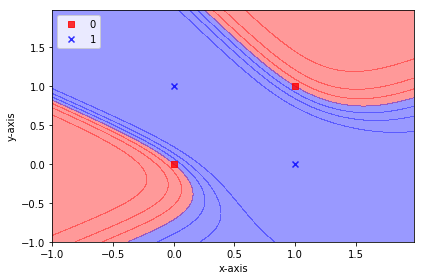

In [143]:
plot_decision_regions(X, y, nn)
plt.xlabel('x-axis')
plt.ylabel('y-axis')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

# 4. What is the point?
> What is the point of this? What is so special about a sequence of Ones and Zeros?

___

#### Venn Diagram of A (XOR) B:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Venn1001.svg/1200px-Venn1001.svg.png" alt="xorv" title="xorv" height="200" width="300"  />

___

### XOR Represents the fundamental logical operation for differentiating between two or more distinct ideas. The ability of the human brain to perform XOR logic gives humans the ability assign independent meanings to words. It allows humans to identify distinct objects. XOR is the key to simulating vision.
___

#### Venn Diagram of A (XOR) B (XOR) C:
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/a/ae/Venn_0110_1001.svg/1024px-Venn_0110_1001.svg.png" alt="xorvs" title="xorvs" height="200" width="300"  />


# 5. Classification of Handwritten Digits
____

<img src="https://ml4a.github.io/images/figures/mnist-input.png" alt="mnist2" title="mnist2"  />

___

<img src="https://3qeqpr26caki16dnhd19sv6by6v-wpengine.netdna-ssl.com/wp-content/uploads/2016/05/Examples-from-the-MNIST-dataset.png" alt="mnist1" title="mnist1" height="200" width="300"  />


## Context: 

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).



## Setup

In [102]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns  # visualization tool
# keras imports for the dataset and building our neural network
from keras.datasets import mnist
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers.core import Dense, Dropout, Activation
from keras.utils import np_utils

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import tensorflow as tf

seed = 42
np.random.seed(seed)

from collections import Counter
import itertools
import os


<p style="page-break-before:always;"></p>


____

## Loading the Data

In [105]:
# Reading the data frames
#Training Data
train_raw = pd.read_csv("mnist_train.csv") 
# data info
print('')
print('Train Data Info :' )
print('------------------' )
train_raw.info()
print('')



Train Data Info :
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 359.3 MB



In [106]:
print('data_train shape:', train_raw.shape)
print('Number of images in train  :', train_raw.shape[0])
train_raw.head() 
#The Head Table = 5 rows × 785 columns 
#The Row = 784 features, 1 label

data_train shape: (60000, 785)
Number of images in train  : 60000


,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
0,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [107]:
z_train = Counter(train_raw['label'])
print(z_train)

Counter({1: 6742, 7: 6265, 3: 6131, 2: 5958, 9: 5949, 0: 5923, 6: 5918, 8: 5851, 4: 5842, 5: 5421})


In [109]:
# Reading the data frames
#Test Data
test_raw = pd.read_csv("mnist_test.csv") 
# data info
print('')
print('Test Data Info :' )
print('------------------' )
test_raw.info()
print('')



Test Data Info :
------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 785 entries, label to 28x28
dtypes: int64(785)
memory usage: 59.9 MB



In [110]:
# Assign features and corresponding labels
#Converting the Pandas frame to numpy 

#Train data
X_train = train_raw.iloc[:,1:].values.astype('float32') # all pixel values in train
y_train_label = train_raw.iloc[:,0].values.astype('int32') # only train labels i.e targets digits

#Test data
X_test = test_raw.iloc[:,1:].values.astype('float32') # or np.array(test.iloc[:,1:],np.float32)  # all pixel values in test
y_test_label = test_raw.iloc[:,0].values.astype('int32') # only test labels i.e targets digits

#X_train = train_raw.iloc[:, 1:785]
#train_label = train_raw.iloc[:, 0]
#X_test = test_raw.iloc[:, 1:785]
#X_test = test_raw.iloc[:, 1:785]

#label values == ['0','1','2','3','4','5','6','7','8','9']
label = np.array(train_raw.iloc[:,0],np.str) #or label =  train_raw.iloc[:,0].values.astype('str')

print('X_train:', X_train)
print('X_train_shape:', X_train.shape)
print('X_test.shape:',X_test.shape)
print('X_test:', X_test)
print('y_train_label:', y_train_label)
print('y_train_label.shape:',y_train_label.shape)
print('y_test_label:', y_test_label)
print('y_test_label.shape:',y_test_label.shape)
print('Label:',label)

X_train: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
X_train_shape: (60000, 784)
X_test.shape: (10000, 784)
X_test: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
y_train_label: [5 0 4 ... 5 6 8]
y_train_label.shape: (60000,)
y_test_label: [7 2 1 ... 4 5 6]
y_test_label.shape: (10000,)
Label: ['5' '0' '4' ... '5' '6' '8']


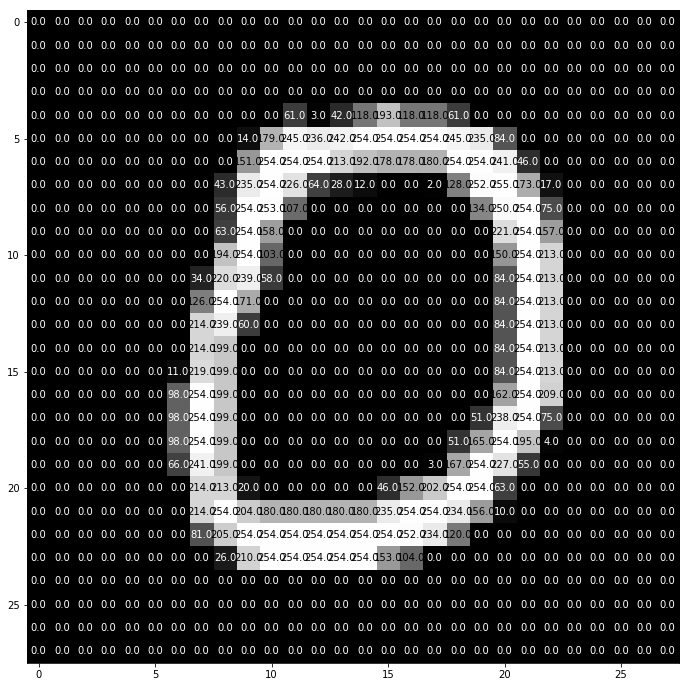

In [111]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
#
visualize_input(X_test[10].reshape(28,28), ax)

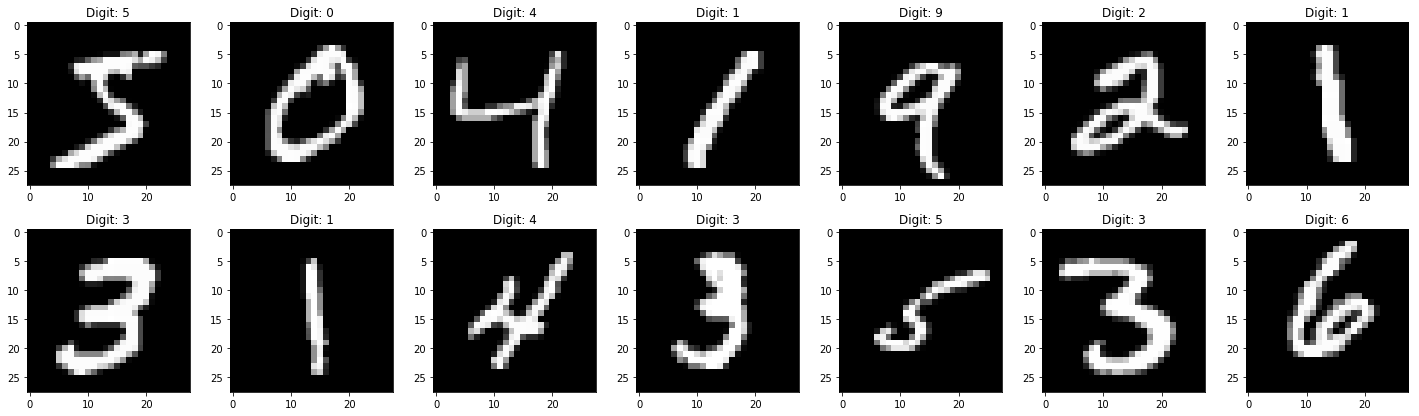

In [112]:
#Drawing Train Data
fig = plt.figure(figsize=(20,20))
for i in range(14):
    ax = fig.add_subplot(7,7,i+1)
    ax.imshow(np.reshape(X_train[i],(28,28)),cmap='gray')
    plt.tight_layout()
    ax.set_title("Digit: {}".format(label[i]))
    #ax.set_title(str(label[i]))
#fig    

In [113]:
# Making sure that the values are float so that we can get decimal points after division
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

In [114]:
# Normalizing the RGB codes by dividing it to the max RGB value(255).
#print((min(X_train[1]), max(X_train[1])))
X_train = X_train / 255
X_test  = X_test / 255

print('X_train matrix shape:', X_train.shape) #_train shape: (42000, 28, 28, 1)
print('Number of images in X_train :', X_train.shape[0]) #Number of images in X_train : 42000
print('X_test matrix shape:', X_test.shape) #X_test shape: (28000, 28, 28, 1)
print('Number of images in X_test  :', X_test.shape[0])#Number of images in X_test  : 28000

X_train matrix shape: (60000, 784)
Number of images in X_train : 60000
X_test matrix shape: (10000, 784)
Number of images in X_test  : 10000


In [115]:
# one-hot encoding using keras' numpy-related utilities
from keras.utils import np_utils
num_classes = 10

print("Shape before one-hot encoding Y_train: ", y_train_label.shape)
print("Shape before one-hot encoding Y_test: ", y_test_label.shape)
Y_train = np_utils.to_categorical(y_train_label, num_classes)
Y_test = np_utils.to_categorical(y_test_label, num_classes)
print("Shape after one-hot encoding Y_train: ", Y_train.shape)
print("Shape after one-hot encoding Y_test: ", Y_test.shape)

Shape before one-hot encoding Y_train:  (60000,)
Shape before one-hot encoding Y_test:  (10000,)
Shape after one-hot encoding Y_train:  (60000, 10)
Shape after one-hot encoding Y_test:  (10000, 10)


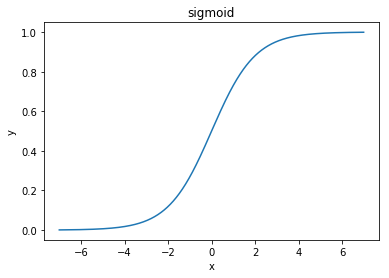

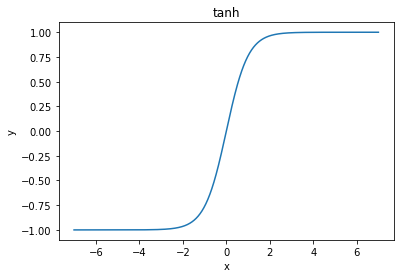

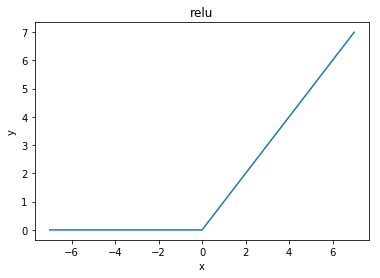

In [116]:
#python simple code
def sigmoid(z):
    output = 1 / (1+np.exp(-z))
    return output

def relu(z):
    return np.maximum(z, 0)

def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))
    
#plot all activation function
import matplotlib.pylab as plt
def plot_function(function, title="sigmoid"):
    x = np.arange(-7, 7, 0.01)
    y = function(x)
    
    plt.plot(x, y)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.show()
    
plot_function(sigmoid, "sigmoid")    
plot_function(tanh, "tanh")
plot_function(relu, "relu")

In [117]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import os

In [118]:
def create_model(input_length, hidden_lenght1, hidden_lenght2, activation_func , 
                 dropout_val,lr_val,num_epochs, batch_size):

    # training the model and saving metrics in history
    model = Sequential()

    model.add(Dense(hidden_lenght1, input_dim=input_length, activation=activation_func))
    model.add(Dropout(dropout_val))

    model.add(Dense(hidden_lenght2, activation=activation_func))
    model.add(Dropout(dropout_val))
    model.add(Dense(10, activation='softmax'))

    lr = lr_val#.001
    adam0 = Adam(lr=lr)

    # Modeli derleyip ve daha iyi bir sonuç elde edildiğinde ağırlıkları kaydedelim
    model.compile(loss='categorical_crossentropy', optimizer=adam0, metrics=['accuracy'])
    filepath = 'tmp_weights.best.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='acc', verbose=1, save_best_only=True, mode='max')
    callbacks_list = [checkpoint]

    # training the model and saving metrics in history
    history_model = model.fit(X_train, Y_train, callbacks=callbacks_list,
                              epochs=num_epochs, batch_size=batch_size, verbose=2,
                                validation_data = (X_test, Y_test))  # verbose 2 or 0 
    return model, history_model

In [122]:
def saving_the_model(model, model_name = 'model_history.h5'):  
    model.save(model_name)
    print('Saved trained model at %s ' % model_name)

In [119]:
def draw_model(training):
    plt.figure()
    plt.subplot(2,1,1)
    plt.plot(training.history['acc'])
    plt.plot(training.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(2,1,2)
    plt.plot(training.history['loss'])
    plt.plot(training.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')

    plt.tight_layout()
    plt.show()    

In [120]:
 #evaluate test accuracy
def scoring_the_model(model_name="model_history.h5"):
    # load the model and create predictions on the test set
    mnist_model = load_model(model_name)
    #1- genel bakış
    loss_and_metrics = mnist_model.evaluate(X_test, Y_test, verbose=2)
    print("Test Loss", loss_and_metrics[0])
    print("Test Accuracy", loss_and_metrics[1])

    #2- test sonrası
    predicted_classes = mnist_model.predict_classes(X_test)
    # see which we predicted correctly and which not
    correct_indices = np.nonzero(predicted_classes == y_test_label)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test_label)[0]
    print()
    print(len(correct_indices)," classified correctly")
    print(len(incorrect_indices)," classified incorrectly")
    
def draw_9_correct_9_incorrect_predictions(model_name="model_history.h5"):  
    # load the model and create predictions on the test set
    mnist_model = load_model(model_name) 
    predicted_classes = mnist_model.predict_classes(X_test)
    correct_indices = np.nonzero(predicted_classes == y_test_label)[0]
    incorrect_indices = np.nonzero(predicted_classes != y_test_label)[0]
    # adapt figure size to accomodate 18 subplots
    plt.rcParams['figure.figsize'] = (7,14)

    plt.figure()
   # print("plot 9 correct predictions")
    # plot 9 correct predictions
    for i, correct in enumerate(correct_indices[:9]):
        plt.subplot(6,3,i+1)
        plt.imshow(X_test[correct].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(
          "Predicted: {}, Truth: {}".format(predicted_classes[correct],
                                            y_test_label[correct]))
        plt.xticks([])
        plt.yticks([])

    #print("plot 9 incorrect predictions")
    # plot 9 incorrect predictions
    for i, incorrect in enumerate(incorrect_indices[:9]):
        plt.subplot(6,3,i+10)
        plt.imshow(X_test[incorrect].reshape(28,28), cmap='gray', interpolation='none')
        plt.title(
          "Predicted {}, Truth: {}".format(predicted_classes[incorrect],
                                           y_test_label[incorrect]))
        plt.xticks([])
        plt.yticks([])

In [ ]:
#parameters
num_epochs = 20
lengh_features = 784 #lengh_features = input layer = 28 pixel  * 28 pixel == 784 node

# Create Model1 # 784-128-128-10 Dropout 0.2,Learning Rate==0.001,Activation Function =relu
# hidden layer start 128 and 2 hidden layer
# activation relu for popular and fast
model1, history_model1 = create_model(input_length=lengh_features,hidden_lenght1=128,hidden_lenght2=128,
                                    activation_func='relu',dropout_val=0.20,
                                    lr_val=0.001,num_epochs=20, batch_size=128
                                    )
# saving the model
saving_the_model(model1,'model1_history.h5')
#model scoring
scoring_the_model('model1_history.h5')

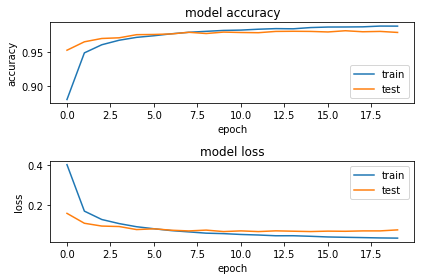

In [124]:
#Model Drawing to visualize the behavior
draw_model(history_model1) 

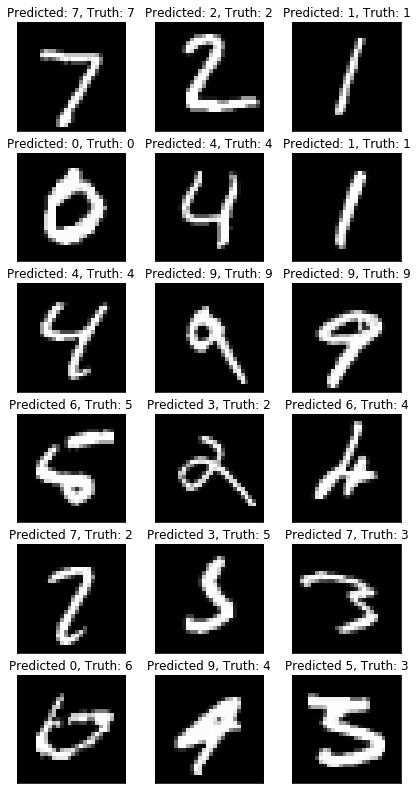

In [125]:
#draw_9 correct_9_incorrect_predictions
draw_9_correct_9_incorrect_predictions('model1_history.h5')